**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS4487 - Tutorial 5
## Predicting Popularity of Online News

In this tutorial you will train a regression function to predict the number of "shares" of a news article on Mashable.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import IPython.utils.warn as warn
random.seed(100)

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
//anaconda/lib/python2.7/

## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `OnlineNewsPopularity.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [2]:
filename = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'

# read the data
allfeatnames = []
textdata      = []
with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(allfeatnames)==0:
            allfeatnames = row
        else:
            textdata.append(row)

# put the data into a np array
dataX = empty((len(textdata), len(allfeatnames)-3))
dataY = empty(len(textdata))
for i,row in enumerate(textdata):
    # extract features (remove the first 2 features and the last feature)
    dataX[i,:] = array(map(float, row[2:-1]))
    # extract target (last entry)
    dataY[i] = float(row[-1])
    
# extract feature names
featnames = map(string.strip, allfeatnames[2:-1])

# extract a subset of data
dataX = dataX[::6]
dataY = dataY[::6]

print dataX.shape
print dataY.shape

(6608, 58)
(6608,)


There are 58 features for each article.  Here are the feature names, and an example entry.  The actual description of the features can be found in the `OnlineNewsPopularity-features.txt` file.

In [3]:
print featnames

print "--- example article features---"
print dataX[0]
print "--- example article target (# of shares)"
print dataY[0]

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarit

Now separate the data into training and testing sets.

In [4]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainYo, testYo = \
  cross_validation.train_test_split(dataX, dataY, 
  train_size=0.50, test_size=0.50, random_state=4487)

print trainX.shape
print testX.shape

(3304, 58)
(3304, 58)


Finally, we normalize the input features.

In [5]:
# normalize feature values
# this makes comparing weights more meaningful
scaler = preprocessing.StandardScaler()  
trainXn = scaler.fit_transform(trainX)  
testXn  = scaler.transform(testX)    

Because the target value (number of shares) has a large dynamic range, we will transform the target values through the log function.

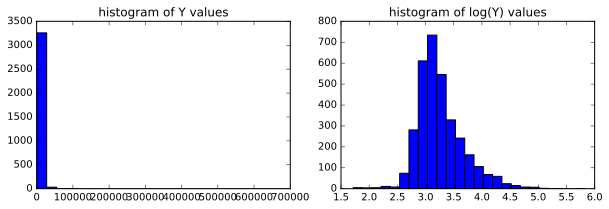

In [6]:
# map targets to log-space
trainY = log10(trainYo)
testY  = log10(testYo)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(trainYo, 25);
plt.title('histogram of Y values')
plt.subplot(1,2,2)
plt.hist(trainY, 25);
plt.title("histogram of log(Y) values");

## 2. Prediction with Linear Regression

First we will look at predicting the number of shares using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [7]:
### INSERT YOUR CODE HERE

ols = linear_model.LinearRegression()
ols.fit(trainXn, trainY)

trainAE = metrics.mean_absolute_error(trainY, ols.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, ols.predict(testXn))

print "train error: " + str(trainAE)
print "test error : " + str(testAE)

train error: 0.286823193052
test error : 188.419524387


best alpha: 16.1026202756
train error: 0.412227512389
test error : 0.408580135622


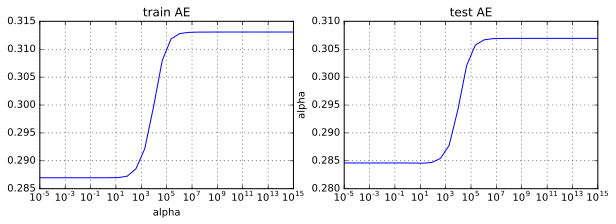

In [8]:
alphas = logspace(-5,15,30)

trainAEs = empty(len(alphas))
testAEs  = empty(len(alphas))
for i,a in enumerate(alphas):
    rr = linear_model.Ridge(alpha=a)
    rr.fit(trainXn, trainY)
    
    trainAEs[i] = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
    testAEs[i]  = metrics.mean_absolute_error(testY, rr.predict(testXn))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.semilogx(alphas, trainAEs)
plt.xlabel('alpha')
plt.title('train AE')
plt.grid(True)
plt.subplot(1,2,2)
plt.semilogx(alphas, testAEs)
plt.ylabel('alpha')
plt.title('test AE')
plt.grid(True)
    
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainX, trainY)

print "best alpha: " + str(rr.alpha_)

trainAE = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY,  rr.predict(testXn))

print "train error: " + str(trainAE)
print "test error : " + str(testAE)

Compare the two models using the _average absolute error_ (AE) between the predictions and the true values.  Below is  code that will calculate AE for the training and test sets.

In [9]:
# ols is the linear regression model
trainAE = metrics.mean_absolute_error(trainY, ols.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, ols.predict(testXn))
print "OLS: train error = " + str(trainAE)
print "OLS: test error = " + str(testAE)

OLS: train error = 0.286823193052
OLS: test error = 188.419524387


In [10]:
# rr is the ridge regression model
trainAE = metrics.mean_absolute_error(trainY, rr.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, rr.predict(testXn))
print "RR: train error = " + str(trainAE)
print "RR: test error = " + str(testAE)

RR: train error = 0.412227512389
RR: test error = 0.408580135622


Which model has better prediction ability on the test set? Why?
- **INSERT YOUR ANSWER HERE**
- RR has better performance. selecting the best alpha prevents overfitting.  
- Lin has severe overfitting -- very bad performance on test set.

# 3. Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [11]:
### INSERT YOUR CODE HERE
las = linear_model.LassoCV()
las.fit(trainXn, trainY)

trainAE = metrics.mean_absolute_error(trainY, las.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, las.predict(testXn))
print trainAE
print testAE

0.288657840068
0.284887079121


Examine the LASSO coefficients by sorting them in descending order.

In [12]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print "weight : feature description"
for i in inds:
    print "% 0.3f : %s" % (las.coef_[i], featnames[i])

weight : feature description
 0.094 : kw_avg_avg
-0.042 : LDA_02
-0.038 : kw_max_avg
-0.034 : data_channel_is_entertainment
-0.027 : average_token_length
 0.025 : global_subjectivity
 0.025 : num_hrefs
 0.022 : kw_min_min
-0.022 : data_channel_is_bus
 0.022 : is_weekend
 0.020 : LDA_00
 0.019 : n_tokens_content
 0.018 : data_channel_is_socmed
-0.018 : kw_avg_min
 0.015 : self_reference_avg_sharess
-0.013 : max_positive_polarity
 0.012 : title_sentiment_polarity
-0.012 : data_channel_is_lifestyle
 0.009 : weekday_is_sunday
-0.008 : LDA_01
-0.007 : avg_negative_polarity
-0.007 : kw_avg_max
 0.007 : n_tokens_title
 0.006 : self_reference_max_shares
 0.006 : num_keywords
-0.006 : kw_min_max
-0.005 : weekday_is_friday
 0.005 : weekday_is_monday
 0.004 : data_channel_is_tech
-0.004 : weekday_is_tuesday
-0.003 : num_self_hrefs
 0.003 : LDA_03
-0.002 : min_positive_polarity
-0.002 : rate_positive_words
 0.002 : num_imgs
 0.002 : self_reference_min_shares
-0.002 : max_negative_polarity
 0.001 :

_Which features are most important for predicting the number of shares?  For these features, which feature values (low or high values) will yield a higher number of shares?_
- **INSERT YOUR ANSWER HERE**
  - kw_avg_avg -- keywords that have large average number of shares (large)
  - LDA02 -- related to LDA topic 2 (low)
  - kw_max_avg -- number of keywords with max shares? (low)
  - data_channel_is_entertainment -- entertainment channel! (low)
  - avg_token_length -- length of words (low)

# 4. Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters.  Hint: avoid using large values of $C$ with SVR.

In [13]:
### INSERT YOUR CODE HERE

In [19]:
allexps = [
    {'name': 'krr-rbf',
     'clf': kernel_ridge.KernelRidge(kernel='rbf'),
     'params': {'alpha': logspace(-3,3,10), 'gamma': logspace(-6,3,10)}
    }, 
    {'name': 'krr-poly',
     'clf': kernel_ridge.KernelRidge(kernel='poly'),
     'params': {'alpha': logspace(-3,3,10), 'degree': [1,2,3,4,5]}
    }, 
    {'name': 'rf',
     'clf': ensemble.RandomForestRegressor(random_state=4487),
     'params': {'n_estimators': array([1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50, 100])}
    }, 
    {'name': 'svr-poly',
     'clf': svm.SVR(kernel='poly'),
     'params':  {'C': logspace(-3,0,5), 'degree': [1,2], 'epsilon': logspace(-2,2,5)}
    }, 
]

clfs = {}
trainAE = {}
testAE = {}
for i,ex in enumerate(allexps):
    myname = ex['name']
    print "=== " + myname + " =================="
    clfs[myname] = grid_search.GridSearchCV(ex['clf'], ex['params'], 
                    scoring='neg_mean_squared_error', cv=5, verbose=1)                               
    clfs[myname].fit(trainXn, trainY)

    print clfs[myname].best_score_
    print clfs[myname].best_params_

    trainAE[myname] = metrics.mean_absolute_error(trainY, clfs[myname].predict(trainXn))
    testAE[myname]  = metrics.mean_absolute_error(testY, clfs[myname].predict(testXn))

    print "train error: " + str(trainAE[myname])
    print "test error : " + str(testAE[myname])

=== krr-rbf ==================
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 11.0min finished


-0.155301215068
{'alpha': 0.001, 'gamma': 0.0001}
train error: 0.271792872809
test error : 0.280557527676
=== krr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  6.6min finished


-0.155257153553
{'alpha': 10.0, 'degree': 2}
train error: 0.268831060682
test error : 0.27956156164
=== rf ==================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.5min finished


-0.15581084918
{'n_estimators': 100}
train error: 0.10954454616
test error : 0.28590017767
=== svr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.1min finished


-0.164113400682
{'epsilon': 0.10000000000000001, 'C': 0.031622776601683791, 'degree': 1}
train error: 0.281246378422
test error : 0.274920172675


In [20]:
# LASSO - poly features
polyfeats = preprocessing.PolynomialFeatures(degree=2)
trainXnf  = polyfeats.fit_transform(trainXn)
testXnf   = polyfeats.transform(testXn) 

myname = 'las-poly'
clfs[myname] = linear_model.LassoCV(max_iter=2000)
clfs[myname].fit(trainXnf, trainY)
trainAE[myname] = metrics.mean_absolute_error(trainY, clfs[myname].predict(trainXnf))
testAE[myname]  = metrics.mean_absolute_error(testY, clfs[myname].predict(testXnf))

print "train error: " + str(trainAE[myname])
print "test error : " + str(testAE[myname])

train error: 0.286457000479
test error : 0.286308695669


In [21]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(clfs['las-poly'].coef_))[::-1]
print len(polyfeats.powers_)
# print out
print "weight : feature description"
for i in inds:
    if abs(clfs['las-poly'].coef_[i])>1e-3:
        # get active features and powers
        pows = where(polyfeats.powers_[i])[0]
        fstr = ""
        for p in pows:
            fstr += featnames[p] + "(" + str(polyfeats.powers_[i][p]) + ") "
        print "% 0.3f : %s" % (clfs['las-poly'].coef_[i], fstr)

1770
weight : feature description
 0.087 : kw_avg_avg(1) 
 0.017 : kw_min_avg(2) 
-0.014 : data_channel_is_entertainment(2) 
-0.012 : LDA_02(2) 
 0.009 : kw_min_min(2) 
 0.009 : kw_max_avg(1) LDA_00(1) 
 0.008 : data_channel_is_socmed(1) LDA_00(1) 
 0.008 : weekday_is_sunday(2) 
 0.007 : n_tokens_content(2) 
-0.007 : data_channel_is_world(1) rate_negative_words(1) 
-0.007 : data_channel_is_world(1) LDA_02(1) 
 0.006 : global_subjectivity(1) 
-0.006 : n_tokens_content(1) num_imgs(1) 
-0.006 : data_channel_is_lifestyle(1) max_positive_polarity(1) 
 0.006 : data_channel_is_tech(2) 
 0.005 : weekday_is_thursday(1) title_sentiment_polarity(1) 
 0.005 : num_keywords(1) kw_avg_max(1) 
 0.005 : num_videos(1) data_channel_is_bus(1) 
-0.005 : weekday_is_monday(1) title_sentiment_polarity(1) 
-0.005 : n_tokens_title(1) n_tokens_content(1) 
-0.005 : kw_max_max(1) title_sentiment_polarity(1) 
 0.005 : num_hrefs(2) 
 0.005 : data_channel_is_socmed(2) 
 0.004 : title_sentiment_polarity(1) abs_title_s

_Which regression method performs the best? Why do you think so?_
- **INSERT YOUR ANSWER HERE**
- polynomial (krr-poly, las-poly, and svr-poly) does slightly better.
- interactions between features is important.